## Imports and preliminaries

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../src'))
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install optax

import splitConformalPrediction
from recursiveLeastSquares import *
from CalibrationScorers.customResidualCalibrationScorer import customResidualCalibrationScorer
from MultivalidAlgorithms.MultivalidCoverage import multivalid_coverage, eval_fn
from DatasetGeneration.DivisibleDataset import divisible_dataset
from MultivalidAlgorithms.GroupCoverage import group_coverage

In [2]:
def produce_group(feat_index, feat_value):
    '''
        Input: 
            - feat_index: index of desired input feature
            - feat_value: desired value of that feature
        Output:
            - f - function which defines a group; f(x) returns True
                  iff x[feat_index] == feat_value and returns False otherwise.
    '''
    def f(x):
      return (x[feat_index] == feat_value)
    
    return f

# Define group that includes all points
def all_points(x):
    return True

basic_group = [all_points]

# Define 20 overlapping sub-groups - each defined by the value of a single binary feature

twenty_groups = list()
num_groups = 0
for i in range(10):
    for j in range(2):
        curr_group = produce_group(i, j)
        twenty_groups.append(curr_group)
        
group_fn_twenty_groups =(lambda x: [group(x) for group in twenty_groups])

num_groups = len(twenty_groups)

## Synthetic Experiment with groups - Comparing conformal prediction methods: Single trial

##### Set all parameters for a single trial

In [3]:
# Parameters for our uncertainty quantifier
T = 40000
tau = 0.9
delta = 0.1
num_grid = 100

# Parameters for data generation
x_std = 0.1
y_std = 0.25
d = 100 # choose d > 10

##### Generating data according to ordinary least-squares model - with some groups adding label-noise (of increasing amount) and others not affecting noise.

In [4]:
theta = np.random.normal(loc=np.zeros(d), scale=x_std)

# d-dimension features - first 10 features are binary
xs_binvars = np.random.randint(low = 0, high = 2, size = (T, 10))
xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(T, d - 10))
xs = np.concatenate((xs_binvars, xs_remvars), axis = 1)
std_dev_list = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
std_dev = np.dot(xs_binvars, std_dev_list) + y_std
ys = np.dot(xs, theta) + np.random.normal(loc=0, scale= std_dev, size=T)

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.5, random_state=42)

In [5]:
# Separate training data into training (for point-predictor) and calibration
calibration_set_size = 15000
train_set_size = len(y_train) - calibration_set_size
x_train_final = x_train[ : train_set_size]
x_calib = x_train[train_set_size : ]
y_train_final = y_train[ : train_set_size]
y_calib = y_train[train_set_size : ]

In [6]:
# Train point-predictor using x_train_final and y_train_final
myRLS = RLS(d, 1.0, 1)
for i in range(train_set_size):
    myRLS.add_obs(x_train_final[i], y_train_final[i])

In [7]:
# Convert y_calib values into threshold values in order to train for conformal prediction 
mult_factor = 250
residualCalibrationScorer = customResidualCalibrationScorer(mult_factor)
residualCalibrationScorer.update(myRLS.predict)

# These are the scores which we want to achieve threshold-calibration with respect to
w_calib = np.array([residualCalibrationScorer.calc_score(x_calib[i], y_calib[i]) for i in range(calibration_set_size)])
w_test = np.array([residualCalibrationScorer.calc_score(x_test[i], y_test[i]) for i in range(len(y_test))])

##### Run each of the 4 methods using x_calib and w_calib to train conformal predictors

In [8]:
# Iterative algorithm for multivalidity 
patches = multivalid_coverage(tau=tau, x_train=x_calib, y_train=w_calib, num_grid=num_grid, group_fn=group_fn_twenty_groups)
multivalid_model = lambda x: eval_fn(x, patches=patches, num_grid=num_grid, group_fn=group_fn_twenty_groups)

Max violation in round 0  :  5686.337444769763
Update: (17, 0, 22)
Max violation in round 1  :  5398.9493401015225
Update: (16, 0, 16)
Max violation in round 2  :  11.072115280043509
Update: (18, 16, 12)
Max violation in round 3  :  15.805184404636465
Update: (15, 16, 20)
Max violation in round 4  :  7.382891440501038
Update: (18, 22, 19)
Max violation in round 5  :  14.85090660841073
Update: (15, 22, 27)
Max violation in round 6  :  5.8906194690265465
Update: (15, 12, 13)
Max violation in round 7  :  5.439313304721022
Update: (10, 12, 8)
Max violation in round 8  :  4.826475770925107
Update: (11, 13, 16)
Max violation in round 9  :  4.732661678246918
Update: (14, 19, 15)
Max violation in round 10  :  4.302250770811928
Update: (13, 19, 22)
Max violation in round 11  :  2.3386446886446848
Update: (12, 16, 13)
Max violation in round 12  :  3.7685955056179745
Update: (9, 16, 20)
Max violation in round 13  :  1.7294759825327561
Update: (9, 13, 15)
Max violation in round 14  :  2.6931905465

In [ ]:
# One-shot algorithm for group coverage
group_accurate_model, opt_theta = group_coverage(tau=tau, x_train=x_calib, y_train=w_calib, num_groups=num_groups, group_fn=group_fn_twenty_groups)

In [12]:
# Training naive conformal predictor and conservative group-wise conformal predictor
marginalConformalPredictor = splitConformalPrediction.splitConformal(1, basic_group, delta)
groupConformalPredictor = splitConformalPrediction.splitConformal(num_groups, twenty_groups, delta)
group_cov_marginal = np.zeros(num_groups)
group_num_marginal = np.zeros(num_groups)
group_cov_group = np.zeros(num_groups)
group_num_group = np.zeros(num_groups)
group_pred_set_size_marginal = np.zeros(num_groups)
group_pred_set_size_group = np.zeros(num_groups)

for i, curr_x in enumerate(x_calib):
    curr_y = y_calib[i]
    marginalConformalPredictor.update_calibration_data(curr_x, curr_y)
    groupConformalPredictor.update_calibration_data(curr_x, curr_y)

In [ ]:
# Running naive conformal predictor and conservative group-wise conformal predictor on test-data

grid_size = 2 * num_grid
marginal_sizes = np.zeros((num_groups, grid_size))
marginal_coverage_total = np.zeros((num_groups, grid_size))
conformal_sizes = np.zeros((num_groups, grid_size))
conformal_coverage_total = np.zeros((num_groups, grid_size))

for i, curr_x in enumerate(x_test):
    curr_y = y_test[i]
    curr_w = w_test[i]
    w_marginal_conformal = marginalConformalPredictor.select_best_width(residualCalibrationScorer, curr_x)
    w_group_conformal = groupConformalPredictor.select_best_width(residualCalibrationScorer, curr_x)
    pred_index1 = int(w_marginal_conformal * grid_size)
    pred_index2 = int(w_group_conformal * grid_size)
    for j in range(num_groups):
        if twenty_groups[j](curr_x) == True:
            group_num_marginal[j] += 1
            group_num_group[j] += 1
            group_cov_marginal[j] += int(w_marginal_conformal > curr_w)
            group_cov_group[j] += int(w_group_conformal > curr_w)
            group_pred_set_size_marginal[j] += 2 * mult_factor * w_marginal_conformal
            group_pred_set_size_group[j] += 2 * mult_factor * w_group_conformal
            marginal_sizes[j][pred_index1] += 1
            marginal_coverage_total[j][pred_index1] += int(w_marginal_conformal > curr_w)
            conformal_sizes[j][pred_index2] += 1
            conformal_coverage_total[j][pred_index2] += int(w_group_conformal > curr_w)

marginal_conformal_coverage = [group_cov_marginal[j]/group_num_marginal[j] for j in range(num_groups)]
group_conformal_coverage = [group_cov_group[j]/group_num_group[j] for j in range(num_groups)]
marginal_conformal_size = [group_pred_set_size_marginal[j]/group_num_marginal[j] for j in range(num_groups)]
group_conformal_size = [group_pred_set_size_group[j]/group_num_group[j] for j in range(num_groups)]

## Plotting Results

##### Plot single method results for either BatchGCP or BatchMVP

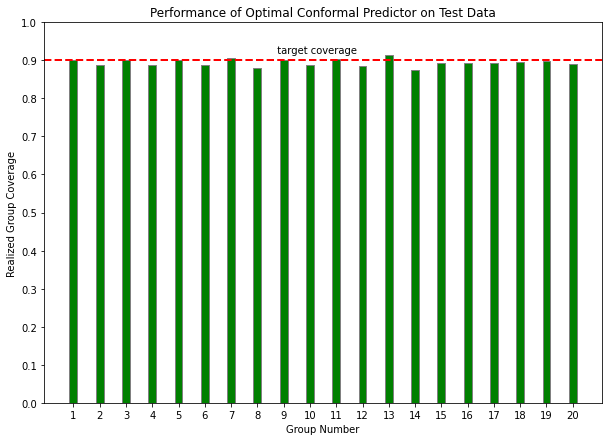

Coverage on group 1 : 0.9015825914935707
Coverage on group 2 : 0.8864509605662285
Coverage on group 3 : 0.9006522829904666
Coverage on group 4 : 0.887593423019432
Coverage on group 5 : 0.9007793764988009
Coverage on group 6 : 0.8874099279423538
Coverage on group 7 : 0.9073073073073074
Coverage on group 8 : 0.8809190809190809
Coverage on group 9 : 0.9009764276555874
Coverage on group 10 : 0.8870297130108509
Coverage on group 11 : 0.9023859023859024
Coverage on group 12 : 0.8856450146479442
Coverage on group 13 : 0.9136400322841001
Coverage on group 14 : 0.8749008723235527
Coverage on group 15 : 0.8939771030363365
Coverage on group 16 : 0.8942240080361628
Coverage on group 17 : 0.8937256079255479
Coverage on group 18 : 0.8944738682921954
Coverage on group 19 : 0.8980942828485456
Coverage on group 20 : 0.8901296111665005


In [10]:
from utils.MultivalidPlotting import plot_group_coverage, plot_all_group_coverage

# To plot single method results - set model param to group_accurate_model, or to multivalid_model
plot_group_coverage(model=multivalid_model, tau=tau, x_test=x_test, y_test=w_test, num_groups=num_groups, group_fn=group_fn_twenty_groups, multivalid=False, verbose=True)

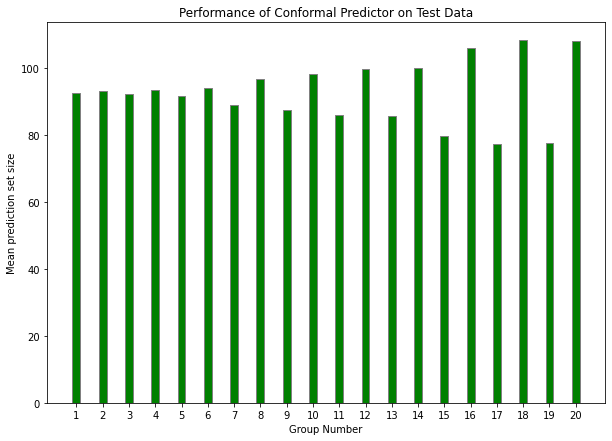

Average prediction set size on group 1 : 92.56330365974283
Average prediction set size on group 2 : 92.98736097067746
Average prediction set size on group 3 : 92.23858504766683
Average prediction set size on group 4 : 93.30368709516692
Average prediction set size on group 5 : 91.66616706634693
Average prediction set size on group 6 : 93.88160528422738
Average prediction set size on group 7 : 88.77577577577577
Average prediction set size on group 8 : 96.76223776223776
Average prediction set size on group 9 : 87.45561692474602
Average prediction set size on group 10 : 98.24029003143697
Average prediction set size on group 11 : 85.9021384021384
Average prediction set size on group 12 : 99.78406909788868
Average prediction set size on group 13 : 85.56093623890234
Average prediction set size on group 14 : 99.85923869944489
Average prediction set size on group 15 : 79.64285714285714
Average prediction set size on group 16 : 106.02184831742842
Average prediction set size on group 17 : 77.3363

In [11]:
from utils.MultivalidPlotting import plot_pred_set_size, plot_all_pred_set_sizes

plot_pred_set_size(model=multivalid_model, tau=tau, x_test=x_test, y_test=w_test, num_groups=num_groups, group_fn=group_fn_twenty_groups, mult_width = mult_factor, multivalid=False, verbose=True)

##### Plot all method results against each other

In [ ]:
# Plotting group-wise coverage

plot_all_group_coverage(group_accurate_model, multivalid_model, tau, x_test, w_test, num_groups, group_fn_twenty_groups, marginal_conformal_coverage, group_conformal_coverage, multivalid=False, bar_width = 0.2)

In [ ]:
# Plotting group-wise prediction set size

plot_all_pred_set_sizes(group_accurate_model, multivalid_model, tau, x_test, y_test, num_groups, group_fn_twenty_groups, mult_factor, marginal_conformal_size, group_conformal_size, multivalid=False, bar_width=0.2)

##### Scatterplot of group-threshold pair coverage against size

In [ ]:
grid_size = 2 * num_grid
multivalid_sizes = np.zeros((num_groups, grid_size))
multivalid_coverage_total = np.zeros((num_groups, grid_size))
group_sizes = np.zeros((num_groups, grid_size))
group_coverage_total = np.zeros((num_groups, grid_size))

group_accurate_multivalid_sizes = np.zeros(num_groups)
group_accurate_multivalid_coverage = np.zeros(num_groups)
group_accurate_multivalid_pred_set_size = np.zeros(num_groups)
group_accurate_group_sizes = np.zeros(num_groups)
group_accurate_group_coverage = np.zeros(num_groups)
group_accurate_group_pred_set_size = np.zeros(num_groups)


for i, test_val in enumerate(x_test):
    pred1 = multivalid_model(test_val)
    pred_index1 = int(pred1 * grid_size)
    pred2 = group_accurate_model(test_val)
    pred_index2 = int(pred2 * grid_size)
    for k in range(num_groups):
        if group_fn_twenty_groups(test_val)[k]:
            multivalid_sizes[k][pred_index1] += 1
            multivalid_coverage_total[k][pred_index1] += int(pred1 > w_test[i])
            group_sizes[k][pred_index2] += 1
            group_coverage_total[k][pred_index2] += int(pred2 > w_test[i])
            group_accurate_multivalid_sizes[k] += 1
            group_accurate_multivalid_coverage[k] += int(pred1 > w_test[i])
            group_accurate_multivalid_pred_set_size[k] += (2 * pred1 * mult_factor)
            group_accurate_group_sizes[k] += 1
            group_accurate_group_coverage[k] += int(pred2 > w_test[i])
            group_accurate_group_pred_set_size[k] += (2 * pred2 * mult_factor)

final_group_coverage = [group_accurate_group_coverage[j]/group_accurate_group_sizes[j] for j in range(num_groups)]
final_multivalid_coverage = [group_accurate_multivalid_coverage[j]/group_accurate_multivalid_sizes[j] for j in range(num_groups)]
final_group_pred_set_size = [group_accurate_group_pred_set_size[j]/group_accurate_group_sizes[j] for j in range(num_groups)]
final_multivalid_pred_set_size = [group_accurate_multivalid_pred_set_size[j]/group_accurate_multivalid_sizes[j] for j in range(num_groups)]   

x_scatter1 = list()
y_scatter1 = list()
x_scatter2 = list()
y_scatter2 = list()
x_scatter3 = list()
y_scatter3 = list()
x_scatter4 = list()
y_scatter4 = list()

for k in range(num_groups):
    for j in range(grid_size):
        if multivalid_sizes[k][j] > 0:
            x_scatter1.append(multivalid_sizes[k][j])
            y_scatter1.append(multivalid_coverage_total[k][j] / multivalid_sizes[k][j])
        if group_sizes[k][j] > 0:
            x_scatter2.append(group_sizes[k][j])
            y_scatter2.append(group_coverage_total[k][j] / group_sizes[k][j])
        if marginal_sizes[k][j] > 0:
            x_scatter3.append(marginal_sizes[k][j])
            y_scatter3.append(marginal_coverage_total[k][j] / marginal_sizes[k][j])
        if conformal_sizes[k][j] > 0:
            x_scatter4.append(conformal_sizes[k][j])
            y_scatter4.append(conformal_coverage_total[k][j] / conformal_sizes[k][j])

In [ ]:
# Plot scatter
plt.figure(figsize=(10, 7))
plt.scatter(x_scatter3, y_scatter3, color='b', alpha = 0.5, label = 'Split-Conformal: Without groups')
plt.scatter(x_scatter4, y_scatter4, color='m', alpha = 0.5, label = 'Split-Conformal: With groups, conservative approach')
plt.scatter(x_scatter1, y_scatter1, color='g', alpha = 0.8, label = 'BatchMVP')
plt.scatter(x_scatter2, y_scatter2, color='c', alpha = 0.5, label = 'BatchGCP')
plt.axhline(y=tau, c='r', linestyle='--', linewidth=2)
plt.text(810, tau + 0.02, '  target coverage')
plt.xlabel('Size of group conditional on threshold')
plt.ylabel('Realized threshold and group conditional coverage')
plt.legend()
plt.show()